# The Data - Online Retail.csv

I'm provided with a sales dataset to use. A summary and preview are provided below.

| Column     | Description              |
|------------|--------------------------|
| `'InvoiceNo'` | A 6-digit number uniquely assigned to each transaction |
| `'StockCode'` | A 5-digit number uniquely assigned to each distinct product |
| `'Description'` | The product name |
| `'Quantity'` | The quantity of each product (item) per transaction |
| `'UnitPrice'` | Product price per unit |
| `'CustomerID'` | A 5-digit number uniquely assigned to each customer |
| `'Country'` | The name of the country where each customer resides |
| `'InvoiceDate'` | The day and time when each transaction was generated `"MM/DD/YYYY"` |
| `'Year'` | The year when each transaction was generated |
| `'Month'` | The month when each transaction was generated |
| `'Week'` | The week when each transaction was generated (`1`-`52`) |
| `'Day'` | The day of the month when each transaction was generated (`1`-`31`) |
| `'DayOfWeek'` | The day of the weeke when each transaction was generated <br>(`0` = Monday, `6` = Sunday) |

# Import Libraries & Data

In [154]:
# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from wordcloud import WordCloud

from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import col, to_date, to_timestamp

from pyspark.ml.feature import VectorAssembler, StringIndexer, Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [155]:
my_spark = SparkSession.builder.appName("SalesForecast")\
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY").getOrCreate()


sales_data = my_spark.read.csv(
    'Online Retail for Big Data.csv',\
          header=True, inferSchema=True, sep=",")
sales_data = sales_data.withColumn("InvoiceDate", to_date(
    to_timestamp(col("InvoiceDate"), "dd/MM/yy HH:mm")))

In [156]:
sales_data.show(5)

+---------+---------+--------------------+--------+---------+----------+--------------+-----------+----+-----+----+---+---------+
|InvoiceNo|StockCode|         Description|Quantity|UnitPrice|CustomerID|       Country|InvoiceDate|Year|Month|Week|Day|DayOfWeek|
+---------+---------+--------------------+--------+---------+----------+--------------+-----------+----+-----+----+---+---------+
|   536365|   85123A|WHITE HANGING HEA...|       6|     2.55|     17850|United Kingdom| 2010-01-12|2010|    1|   2| 12|        1|
|   536365|    71053| WHITE METAL LANTERN|       6|     3.39|     17850|United Kingdom| 2010-01-12|2010|    1|   2| 12|        1|
|   536365|   84406B|CREAM CUPID HEART...|       8|     2.75|     17850|United Kingdom| 2010-01-12|2010|    1|   2| 12|        1|
|   536365|   84029G|KNITTED UNION FLA...|       6|     3.39|     17850|United Kingdom| 2010-01-12|2010|    1|   2| 12|        1|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|     3.39|     17850|United Kingdom| 20

In [157]:
sales_data.printSchema()

root
 |-- InvoiceNo: integer (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- InvoiceDate: date (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Week: integer (nullable = true)
 |-- Day: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)



# EDA

In [158]:
sales_data_da = sales_data.withColumn('Total Sales', col('UnitPrice')*col('Quantity')).orderBy('InvoiceDate')
sales_data_da.show(5)

+---------+---------+--------------------+--------+---------+----------+--------------+-----------+----+-----+----+---+---------+------------------+
|InvoiceNo|StockCode|         Description|Quantity|UnitPrice|CustomerID|       Country|InvoiceDate|Year|Month|Week|Day|DayOfWeek|       Total Sales|
+---------+---------+--------------------+--------+---------+----------+--------------+-----------+----+-----+----+---+---------+------------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|     2.55|     17850|United Kingdom| 2010-01-12|2010|    1|   2| 12|        1|15.299999999999999|
|   536365|    71053| WHITE METAL LANTERN|       6|     3.39|     17850|United Kingdom| 2010-01-12|2010|    1|   2| 12|        1|             20.34|
|   536365|   84406B|CREAM CUPID HEART...|       8|     2.75|     17850|United Kingdom| 2010-01-12|2010|    1|   2| 12|        1|              22.0|
|   536365|   84029G|KNITTED UNION FLA...|       6|     3.39|     17850|United Kingdom| 2010-01-12|2010|  

24/10/22 00:50:18 WARN StopWordsRemover: Default locale set was [en_BD]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


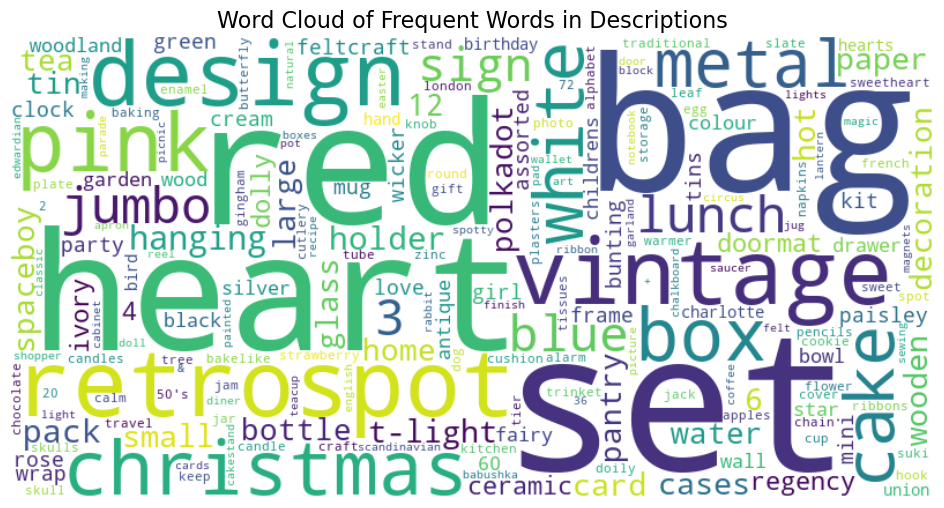

In [159]:
tokenizer = Tokenizer(inputCol="Description", outputCol="words")
tokenized_data = tokenizer.transform(sales_data_da)

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
clean_data = remover.transform(tokenized_data)

exploded_data = clean_data.select(F.explode(F.col("filtered_words")).alias("word"))
word_count = exploded_data.groupBy("word").count().orderBy(F.desc("count"))
word_count_pd = word_count.toPandas()

word_freq_dict = dict(zip(word_count_pd['word'], word_count_pd['count']))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Frequent Words in Descriptions', fontsize=16)
plt.show()

In [160]:
entry_count = sales_data_da.select('CustomerID').count()
customer_count = sales_data_da.select('CustomerID').distinct().count()
invoice_count = sales_data_da.select('InvoiceNo').distinct().count()
stock_count = sales_data_da.select('StockCode').distinct().count()
country_count = sales_data_da.select('Country').distinct().count()

print(f'\
      Total entries: {entry_count}\n\
      Total customers: {customer_count}\n\
      Total Invoices: {invoice_count}\n\
      Total Stocks: {stock_count}\n\
      Total Countries: {country_count}')

      Total entries: 384721
      Total customers: 4261
      Total Invoices: 17635
      Total Stocks: 3649
      Total Countries: 37


## Total Sales($) by Date

In [161]:
daily_sales = sales_data_da.groupBy('InvoiceDate').agg(F.sum('Total Sales').alias('Total Sales'))
daily_sales_pd = daily_sales.toPandas()
daily_sales_pd['InvoiceDate'] = pd.to_datetime(daily_sales_pd['InvoiceDate'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=daily_sales_pd['InvoiceDate'], 
                         y=daily_sales_pd['Total Sales'], 
                         mode='lines+markers', 
                         name='Total Sales',
                         marker=dict(size=4),
                         line=dict(width=1)))
fig.update_layout(
    title='Daily Total Sales Over Time',
    xaxis_title='Date',
    yaxis_title='Total Sales ($)',
    xaxis=dict(tickformat='%Y-%m-%d'),
    showlegend=False,
    template='plotly_white'
)

# Show the plot
fig.show()

## Total Sales($) by Month

In [162]:
monthly_sales = sales_data_da.groupBy(F.month('InvoiceDate').alias('Month')).agg(F.sum('Total Sales').alias('Total Sales'))
monthly_sales_pd = monthly_sales.toPandas().sort_values('Month')
monthly_sales_pd['Month'] = monthly_sales_pd['Month'].apply(lambda x: pd.to_datetime(f'2024-{x}-01').strftime('%B'))


fig = go.Figure()
fig.add_trace(go.Bar(x=monthly_sales_pd['Month'],y=monthly_sales_pd['Total Sales']))
fig.update_layout(
    title='Total Sales by Month',
    xaxis_title='Month',
    yaxis_title='Total Sales ($)',
    xaxis_tickangle=-45,
    template='plotly_white'
)
fig.show()

## Total Sales($) by Week Day

In [163]:
weekday_sales = sales_data_da.groupBy('DayOfWeek').agg(F.sum('Total Sales').alias('Total Sales'))
weekday_sales_pd = weekday_sales.toPandas().sort_values('DayOfWeek')
days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
weekday_sales_pd['DayOfWeek'] = weekday_sales_pd['DayOfWeek'].apply(lambda x: days_of_week[x])

fig = go.Figure()
fig.add_trace(go.Bar(
    x=weekday_sales_pd['DayOfWeek'],
    y=weekday_sales_pd['Total Sales']
))
fig.update_layout(
    title='Total Sales by Day Of Week',
    xaxis_title='Day Of Week',
    yaxis_title='Total Sales ($)',
    xaxis_tickangle=-45,
    template='plotly_white'
)
fig.show()

In [164]:
country_grouped = sales_data_da.groupBy('Country').agg(F.sum('Total Sales').alias('Total Sales'))
country_grouped_pd = country_grouped.toPandas().sort_values('Total Sales', ascending=False)[1:11]

fig = go.Figure()
fig.add_trace(go.Bar(
    x=country_grouped_pd['Country'],
    y=country_grouped_pd['Total Sales']
))
fig.update_layout(
    title='Top 10 Countries Outside of UK with Total Sales',
    xaxis_title='Country',
    yaxis_title='Total Sales ($)',
    xaxis_tickangle=-45,
    template='plotly_white'
)
fig.show()

# Machine Learning Workflow

## Creating Dataset by Grouping

In [165]:
sales_data_grouped = sales_data.groupBy(["Country", "StockCode", "InvoiceDate", "Year", "Month", "Day", "Week", "DayOfWeek"]).agg({'Quantity':'sum', 'UnitPrice': 'avg'})
sales_data_grouped = sales_data_grouped.withColumnRenamed('avg(UnitPrice)', 'UnitPrice').withColumnRenamed('sum(Quantity)', 'Quantity')
sales_data_grouped.show(10)

+--------------+---------+-----------+----+-----+---+----+---------+---------+--------+
|       Country|StockCode|InvoiceDate|Year|Month|Day|Week|DayOfWeek|UnitPrice|Quantity|
+--------------+---------+-----------+----+-----+---+----+---------+---------+--------+
|United Kingdom|    22912| 2010-01-12|2010|    1| 12|   2|        1|     4.95|       3|
|        France|    22659| 2010-01-12|2010|    1| 12|   2|        1|     1.95|      24|
|United Kingdom|    21544| 2010-01-12|2010|    1| 12|   2|        1|     0.85|      12|
|United Kingdom|    21098| 2010-01-12|2010|    1| 12|   2|        1|     1.25|      16|
|        Norway|    85150| 2010-01-12|2010|    1| 12|   2|        1|     2.55|      12|
|United Kingdom|    22195| 2010-01-12|2010|    1| 12|   2|        1|     1.65|       5|
|United Kingdom|    21668| 2010-01-12|2010|    1| 12|   2|        1|     1.25|      18|
|United Kingdom|    21844| 2010-02-12|2010|    2| 12|   6|        4|     2.95|      12|
|United Kingdom|    22914| 2010-

## Train Test Split

In [166]:
train = sales_data_grouped.filter(col('InvoiceDate')<="2011-09-25")
test = sales_data_grouped.filter(col('InvoiceDate')>"2011-09-25")

## Build Regression Model

In [167]:
# StringIndexer for each column
stringIndexer_country = StringIndexer(inputCol='Country', outputCol='Country_Index').setHandleInvalid("keep")
stringIndexer_stockcode = StringIndexer(inputCol='StockCode', outputCol='StockCode_Index').setHandleInvalid("keep")

indexer_country = stringIndexer_country.fit(train)
indexer_stockcode = stringIndexer_stockcode.fit(train)

indexed = indexer_country.transform(train)
indexed = indexer_stockcode.transform(indexed)

assembler = VectorAssembler(inputCols=['Country_Index', 'StockCode_Index', "Month", "Year",
                "DayOfWeek", "Day", "Week"], outputCol='features')

rf = RandomForestRegressor(labelCol="Quantity", featuresCol="features", maxBins = 4000)

pipeline = Pipeline(stages=[indexer_country, indexer_stockcode, assembler, rf])

## Model Training

In [168]:
model = pipeline.fit(train)
predictions = model.transform(test)
predictions = predictions.withColumn("prediction", col("prediction").cast("double"))

24/10/22 00:50:28 WARN DAGScheduler: Broadcasting large task binary with size 1049.0 KiB
24/10/22 00:50:28 WARN DAGScheduler: Broadcasting large task binary with size 1894.7 KiB
24/10/22 00:50:29 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


## Model Evaluation

In [169]:
mae_evaluator = RegressionEvaluator(labelCol='Quantity', predictionCol='prediction', metricName='mae')
mae = mae_evaluator.evaluate(predictions)
print(mae)

9.815039346537532


In [170]:
# Weekly Sales Prediction
weekly_sales = predictions.groupBy(['Year', 'Week']).agg({'prediction':'sum'})\
        .withColumn('Quantity Sold',col('sum(prediction)').cast('int'))\
            .drop('sum(prediction)').orderBy('Week')
weekly_sales.show()

+----+----+-------------+
|Year|Week|Quantity Sold|
+----+----+-------------+
|2011|  39|        91611|
|2011|  40|        50757|
|2011|  41|        86658|
|2011|  42|       100959|
|2011|  43|       100968|
|2011|  44|        59909|
|2011|  45|        97740|
|2011|  46|       117676|
|2011|  47|       110280|
|2011|  48|        74396|
|2011|  49|        65924|
+----+----+-------------+

